# Data science task - Will Nowak

In this notebook, I will use teacher characteristic data and teacher effectiveness data as evidence to answer the following questions:

1. What applicant information best predicts effectiveness?
    1. What did you choose as your outcome variable? Why?
2. What (if any) pieces of data do you wish was collected? 
    1. Is there a way to use existing data to approximate the effects of this data?
3. What (if any) challenges existed with using and interpreting information from this data set? 
    1. How did you resolve these challenges?
4. What recommendations would you give to a school district based on these results?



In [625]:
# Imports:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [626]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

In [627]:
np.random.seed(1234)

## Exploratory data analysis

In [628]:
applicant = pd.read_csv('Data/Data Science Task_Applicant Data.csv')
effectiveness = pd.read_csv('Data/Data Science Test_Effectiveness Data.csv')

The applicant data contains data on {{applicant.shape[0]}} applicants, with {{applicant.shape[1]}} potential variables describing the candidate and their application. Crucially, applicants without an 'Employee ID' were **not** hired. 

In [629]:
applicant.head(2)

,App Date,Gender,Diverse Origin?,UG Degree,UG GPA,Grad Degree,Resume Screen Score,Phone Screen Score,Phone Screen Score - Responsibility,Phone Screen Score - Interpersonal Skills,...,Other Language,FT Teach Experience,Low Income Teach Experience,Youth Experience,Self-Described Phrase,Self-Described Phrase.1,Self-Described Phrase.2,Self-Described Phrase.3,Self-Described Phrase.4,Employee ID
0,12/5/2014,W,Yes,NaN,0.00,NaN,3-RECOMMEND,99-NOT DETERMINED,NaN,NaN,...,NaN,f) 4,f) 4,f) 4,Avid Listener,Confident,Data Driven,Disciplined,Engaged,NaN
1,12/8/2014,NaN,No,Social Studies,2.85,Education: Other,2-HIGHLY RECOMMEND,2-HIGHLY RECOMMEND,2-HIGHLY RECOMMEND,3-RECOMMEND,...,NaN,c) 1,c) 1,c) 1,Reflective,Community Focused,Dedicated,Data Driven,Disciplined,100263541.0


The effecitiveness data contains data on {{effectiveness.shape[0]}} hired teachers, with {{effectiveness.shape[1]-1}} variables describing their effectiveness.

In [630]:
effectiveness.head(2)

,Employee ID,Active Employee,Overall Rating,Rating Points,Student Growth Rating,Student Growth Points,Teaching Obs Score,Exhibits High Expectations Score,Supportiveof Students Score
0,100006086.0,Yes,A,51.42,A,20.9,72%,86%,82%
1,100019596.0,Yes,E,70.25,E,38.0,79%,88%,83%


We are told that each row represents a teacher, but let's just ensure they are all unique.

In [631]:
if len(effectiveness['Employee ID'].unique()) == effectiveness.shape[0]:
    print('Every row corresponds to a unique teacher.')
else:
    print('Some rows contain data on the same teacher.')

Some rows contain data on the same teacher.


In [632]:
print('There are {} duplicates.'.format(effectiveness.shape[0] - len(effectiveness['Employee ID'].unique())))

There are 5 duplicates.


In fact, we have {{len(effectiveness['Employee ID'].unique())}} unique employee IDs, but the dataframe has {{effectiveness.shape[0]}} rows, so we have {{effectiveness.shape[0] - len(effectiveness['Employee ID'].unique())}} duplicates.

In [633]:
pd.DataFrame(effectiveness['Employee ID'].value_counts()).reset_index().head(5)

,index,Employee ID
0,100000000.0,6
1,100018043.0,1
2,100250783.0,1
3,100019378.0,1
4,100270661.0,1


The above shows we were wrong...we actually just have 'Employee ID' 100000000.0 showing up 6 times. I'm unsure what exactly is going on here but let's just drop that employee(s?) and move on.

In [634]:
effectiveness_df = effectiveness.drop(effectiveness[effectiveness['Employee ID'] == 100000000.0].index)

In [635]:
if len(effectiveness_df['Employee ID'].unique()) == effectiveness_df.shape[0]:
    print('Every row in the effectiveness data now corresponds to a unique teacher.')
else:
    print('Some rows contain data on the same teacher.')

Every row in the effectiveness data now corresponds to a unique teacher.


I would check for duplicates in the application dataframe too, but there is no variable that is in theory a unique id (since 'Employee ID' is only assigned to hired teachers). 

In [636]:
# Make sure App Date is recognized as a date.
applicant['App Date'] = pd.to_datetime(applicant['App Date'])

In [637]:
# Confirm it is.
applicant['App Date'].dtype

dtype('<M8[ns]')

In [638]:
applicant[applicant.duplicated()].sort_values(by='App Date')[1:5]

,App Date,Gender,Diverse Origin?,UG Degree,UG GPA,Grad Degree,Resume Screen Score,Phone Screen Score,Phone Screen Score - Responsibility,Phone Screen Score - Interpersonal Skills,...,Other Language,FT Teach Experience,Low Income Teach Experience,Youth Experience,Self-Described Phrase,Self-Described Phrase.1,Self-Described Phrase.2,Self-Described Phrase.3,Self-Described Phrase.4,Employee ID
23,2014-12-09,F,Yes,Elementary Education,0.0,NaN,4-RECOMMEND W/RESERV,3-RECOMMEND,3-RECOMMEND,3-RECOMMEND,...,NaN,c) 1,c) 1,g) 5+,Avid Learner,Dedicated,Reflective,Data Driven,Encouraging,NaN
39,2014-12-14,M,No,"Art, Photography/Related Media",0.0,Education: Other,2-HIGHLY RECOMMEND,2-HIGHLY RECOMMEND,2-HIGHLY RECOMMEND,3-RECOMMEND,...,NaN,g) 5+,g) 5+,g) 5+,Dedicated,Creative,Patient,Reflective,Community Focused,NaN
2298,2014-12-15,F,No,NaN,0.0,Curriculum and Instruction,3-RECOMMEND,3-RECOMMEND,3-RECOMMEND,3-RECOMMEND,...,NaN,b) < 1,b) < 1,e) 3,Dedicated,Inspiring,Leader,Passionate,Organized,100265225.0
69,2014-12-16,F,No,Elementary Education,0.0,NaN,4-RECOMMEND W/RESERV,4-RECOMMEND W/RESERV,3-RECOMMEND,3-RECOMMEND,...,NaN,f) 4,d) 2,g) 5+,Encouraging,Positive,Patient,Organized,Dedicated,100265464.0


So something funky is going on. It says we do have duplicates in the dataframe, but manual inspection does not show this to be the case. Pandas has been reported to have this as a [bug](https://github.com/pandas-dev/pandas/issues/11436). We'll assume it is a bug and move on with the entire applicant dataframe as is.

## Data processing

** Moving forward, the applicant and effectiveness_df are assumed free of duplicates and to be used. **

We need to address two concerns:


1. Determine what outcome variable(s) is of interest.
2. Prepare training features for a model. That is, we have many qualitative variables in the feature set, and we need to make sure a machine learning model can handle them.

### Determine outcome variable

We are given multiple measure of teacher effectiveness:

In [639]:
effectiveness_df.head(3)

,Employee ID,Active Employee,Overall Rating,Rating Points,Student Growth Rating,Student Growth Points,Teaching Obs Score,Exhibits High Expectations Score,Supportiveof Students Score
0,100006086.0,Yes,A,51.42,A,20.9,72%,86%,82%
1,100019596.0,Yes,E,70.25,E,38.0,79%,88%,83%
2,100192425.0,Yes,E,79.85,E,42.0,NaN,NaN,NaN


But what does it mean?? One big challenge of this challenge is that we have very little context re: the output variables. That is, the whole point of this task is predict and find predictors of teacher success...but how we define teacher success is unclear. So let's try to do that here.

Overall rating seems like a nice title, but the outcomes for it are puzzling.

In [640]:
effectiveness_df['Overall Rating'].value_counts()

E                          2970
D                          1008
A                           585
Insufficient                363
NM                           18
Pending Leader Decision       2
Pending                       1
Name: Overall Rating, dtype: int64

A quick google search didn't tell me anything about what these grades might mean. However, I am going to assume that more 'Rating Points' implies a better teacher performance, so let's dig into that.

/Users/wnowak/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


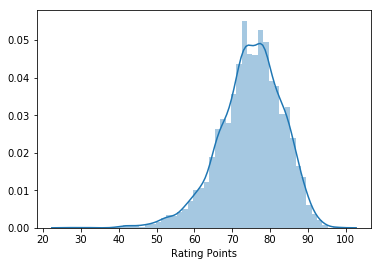

In [641]:
sns.distplot(effectiveness_df['Rating Points'].dropna())

A nice normalish distribution, with points centered at a median of {{effectiveness_df['Rating Points'].dropna().median()}}.

/Users/wnowak/anaconda/envs/py35/lib/python3.5/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


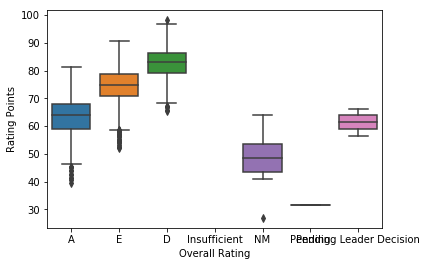

In [642]:
# Out of curiosity:
sns.boxplot(x='Overall Rating', y="Rating Points", data=effectiveness_df)

So it actually seems like 'A' is the worst grade, if we assume that more rating points are better.

Anyways, we could delve into this more, and we probably should, but in the interest of time, let's for now simply take the 'Rating Points' as our outcome variable of choice. We'll assume that more points means a 'better teacher', and this is what we want to select for. 'Rating Points' makes for a more nuanced criterion variable because it has a large spread (s.d. of {{effectiveness_df['Rating Points'].dropna().std()}}).

### Prepare training data for model

Let's put everything we want to train on together:

In [643]:
# Criterion (output) variable
criterion = 'Rating Points'
output = effectiveness_df[['Employee ID',criterion]]

In [644]:
train_df = output.merge(applicant, how='inner', on='Employee ID')

In [645]:
train_df.head()

,Employee ID,Rating Points,App Date,Gender,Diverse Origin?,UG Degree,UG GPA,Grad Degree,Resume Screen Score,Phone Screen Score,...,Other Language Fluent?,Other Language,FT Teach Experience,Low Income Teach Experience,Youth Experience,Self-Described Phrase,Self-Described Phrase.1,Self-Described Phrase.2,Self-Described Phrase.3,Self-Described Phrase.4
0,100250922.0,68.91,2015-01-08,NaN,No,Elementary Education,3.68,NaN,3-RECOMMEND,3-RECOMMEND,...,NO,NaN,b) < 1,f) 4,g) 5+,Avid Learner,Creative,Data Driven,Leader,Innovative
1,100266008.0,61.52,2015-02-17,M,No,Elementary Education,0.00,Education: Other,3-RECOMMEND,3-RECOMMEND,...,NO,NaN,d) 2,d) 2,d) 2,Confident,Data Driven,Flexible,Reflective,Dedicated
2,100266484.0,NaN,2016-02-24,NaN,Yes,Other Degree,3.87,Education: Other,3-RECOMMEND,2-HIGHLY RECOMMEND,...,NO,NaN,a) 0,f) 4,g) 5+,Dedicated,Flexible,Relationship Builder,Reflective,Data Driven
3,100266485.0,72.84,2015-02-21,F,No,Elementary Education,0.00,NaN,3-RECOMMEND,3-RECOMMEND,...,NO,NaN,d) 2,d) 2,g) 5+,Dedicated,Energetic,Open-Minded,Positive,Passionate
4,100266808.0,69.41,2015-01-07,M,No,"Spec Ed, Generalist",0.00,NaN,3-RECOMMEND,3-RECOMMEND,...,NO,NaN,e) 3,a) 0,e) 3,Dedicated,Relationship Builder,Encouraging,Reflective,Passionate


In [646]:
print(train_df.shape)

(1136, 32)


So we only have {{train_df.shape[0]}} teachers that were hired that we have applicant data on. This is surprising. I would have thought that the applicant data size > the hired data size, but they were about the same, and the intersection of the two is much smaller than the hired data set alone, indicating that we have teacher effectiveness data for teachers that we don't have applicants data. **Maybe we can use all this 'extra' data at some point. If I don't address that more, note it as a point of interest to return to.**

My idea would be to take the teachers that were not hired and assign them some low Rating score (under the assumption that since they were not hired, they would do poorly and get bad scores). This tactic might increase the predictive ability of our models.

In [647]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1136 entries, 0 to 1135
Data columns (total 32 columns):
Employee ID                                  1136 non-null float64
Rating Points                                1075 non-null float64
App Date                                     1136 non-null datetime64[ns]
Gender                                       865 non-null object
Diverse Origin?                              1136 non-null object
UG Degree                                    939 non-null object
UG GPA                                       1136 non-null float64
Grad Degree                                  563 non-null object
Resume Screen Score                          1136 non-null object
Phone Screen Score                           1136 non-null object
Phone Screen Score - Responsibility          1133 non-null object
Phone Screen Score - Interpersonal Skills    1133 non-null object
Phone Screen Score - Critical Thinking       1133 non-null object
Phone Screen Score - Commun

We have a lot of qualitative variables (objects), and we need to address this for our model. 

#### Model choice

Given the qualitative nature of the predictors and their non-linearity, and the relatively small size of our data, I think that a decision tree model would be best. I've had good luck using XGB, as have others, so we'll plan ahead with that.

#### Eliminate date

Before we finish, we also need to handle the date object.

In [648]:
# Pull out features of application date that are numeric
train_df['year'] = train_df['App Date'].dt.year
train_df['month'] = train_df['App Date'].dt.month
train_df['day'] = train_df['App Date'].dt.day

In [649]:
# Drop the date from the train_df
train_df.drop('App Date', axis = 1, inplace=True)

#### Combine common responses

In [650]:
train_df['UG Degree'].value_counts()[0:20]

Elementary Education           146
Not applicable                 107
English                         63
Secondary Education             50
Soc Sciences, Psychology        40
Other Degree                    39
Education: Other                32
Soc Sciences, History           31
Foreign Languages, Spanish      29
General Pre-School Educ         22
Mathematics                     22
Science, Biology                21
English, Literature             20
Soc Sciences, Political Sci     19
ART                             16
English, Journ/Mass Comm        16
Music                           16
Business, Marketing             16
Social Studies                  15
Physical Education              14
Name: UG Degree, dtype: int64

In the 'UG Degree' variable, there is a lot of redundancy. Let's see if we can eliminate and simplify this.

In [651]:
train_df['UG Degree'] = np.where(train_df['UG Degree'].str.contains('English', case = False),'English',train_df['UG Degree'])
train_df['UG Degree'] = np.where(train_df['UG Degree'].str.contains('Soc', case = False),'Social Science',train_df['UG Degree'])

train_df['UG Degree'] = np.where(train_df['UG Degree'].str.contains('Education', case = False),'Education',train_df['UG Degree'])
train_df['UG Degree'] = np.where(train_df['UG Degree'].str.contains('Educ', case = False),'Education',train_df['UG Degree'])
train_df['UG Degree'] = np.where(train_df['UG Degree'].str.contains('Teacher', case = False),'Education',train_df['UG Degree'])
train_df['UG Degree'] = np.where(train_df['UG Degree'].str.contains('Ed', case = False),'Education',train_df['UG Degree'])
train_df['UG Degree'] = np.where(train_df['UG Degree'].str.contains('Physical Curr', case = False),'Education',train_df['UG Degree'])

train_df['UG Degree'] = np.where(train_df['UG Degree'].str.contains('Spanish', case = False),'Foreign Language',train_df['UG Degree'])
train_df['UG Degree'] = np.where(train_df['UG Degree'].str.contains('French', case = False),'Foreign Language',train_df['UG Degree'])
train_df['UG Degree'] = np.where(train_df['UG Degree'].str.contains('German', case = False),'Foreign Language',train_df['UG Degree'])
train_df['UG Degree'] = np.where(train_df['UG Degree'].str.contains('Business', case = False),'Business',train_df['UG Degree'])
train_df['UG Degree'] = np.where(train_df['UG Degree'].str.contains('Art', case = False),'Art',train_df['UG Degree'])
train_df['UG Degree'] = np.where(train_df['UG Degree'].str.contains('Biology', case = False),'Physical Sciences',train_df['UG Degree'])
train_df['UG Degree'] = np.where(train_df['UG Degree'].str.contains('Environmental', case = False),'Physical Sciences',train_df['UG Degree'])
train_df['UG Degree'] = np.where(train_df['UG Degree'].str.contains('Chemistry', case = False),'Physical Sciences',train_df['UG Degree'])

# train_df['UG Degree'] = np.where(train_df['UG Degree'].str.contains('Science', case = False),'Physical Sciences',train_df['UG Degree'])
train_df['UG Degree'] = np.where(train_df['UG Degree'].str.contains('Math', case = False),'Math',train_df['UG Degree'])
train_df['UG Degree'] = np.where(train_df['UG Degree'].str.contains('Music', case = False),'Music',train_df['UG Degree'])

train_df['UG Degree'] = np.where(train_df['UG Degree'].str.contains('Health', case = False),'Health',train_df['UG Degree'])

In [654]:
train_df['UG Degree'].value_counts()[0:20]

English                    318
Education                  309
Social Science             145
Not applicable             107
Art                         42
Business                    42
Other Degree                39
Foreign Language            32
Physical Sciences           31
Music                       25
Math                        23
Health                       6
Science                      5
Foreign languages            4
Linguistically Diff ESL      3
Criminal Justice             2
AGRICULTURE                  1
Law                          1
Agriculture, Forestry        1
Name: UG Degree, dtype: int64

In [656]:
# If degree now not in top 12, call other:
train_df['UG Degree'] = np.where(~train_df['UG Degree'].isin(train_df['UG Degree'].value_counts()[0:11].index), 'Other', train_df['UG Degree'])

In [657]:
train_df['UG Degree'].value_counts()[0:20]

English              318
Education            309
Social Science       145
Not applicable       107
Art                   42
Business              42
Other Degree          39
Foreign Language      32
Physical Sciences     31
Music                 25
Math                  23
Other                 23
Name: UG Degree, dtype: int64

#### Handle qualitative features

Some qualitative features are categorical ('Gender') and some are ordinal ('Resume Screen Score'), so we need to handle these differently, perhaps. There is actually much [debate in the ML community](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) about how to pre-process qualititive data...and some good evidence shows that, currently, the naive approach of converting each category to a numeric variable performs well. Let's do that here first and then we can adjust later if we decide to. 

In [658]:
# Keep an original, not encoded df too
original_train_df = train_df.copy()

In [659]:
original_train_df.head(1)

,Employee ID,Rating Points,Gender,Diverse Origin?,UG Degree,UG GPA,Grad Degree,Resume Screen Score,Phone Screen Score,Phone Screen Score - Responsibility,...,Low Income Teach Experience,Youth Experience,Self-Described Phrase,Self-Described Phrase.1,Self-Described Phrase.2,Self-Described Phrase.3,Self-Described Phrase.4,year,month,day
0,100250922.0,68.91,NaN,No,Education,3.68,NaN,3-RECOMMEND,3-RECOMMEND,3-RECOMMEND,...,f) 4,g) 5+,Avid Learner,Creative,Data Driven,Leader,Innovative,2015,1,8


In [660]:
# Convert to numeric using sklearn Label Encoder.
for c in train_df.columns:
#     train_df[c]=train_df[c].fillna(-1)
    if train_df[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train_df[c].values))
        train_df[c] = lbl.transform(list(train_df[c].values))

In [661]:
original_train_df.head(1)

,Employee ID,Rating Points,Gender,Diverse Origin?,UG Degree,UG GPA,Grad Degree,Resume Screen Score,Phone Screen Score,Phone Screen Score - Responsibility,...,Low Income Teach Experience,Youth Experience,Self-Described Phrase,Self-Described Phrase.1,Self-Described Phrase.2,Self-Described Phrase.3,Self-Described Phrase.4,year,month,day
0,100250922.0,68.91,NaN,No,Education,3.68,NaN,3-RECOMMEND,3-RECOMMEND,3-RECOMMEND,...,f) 4,g) 5+,Avid Learner,Creative,Data Driven,Leader,Innovative,2015,1,8


#### Delete Rating Points NA

Lastly, we need to get rid of observations that we don't have Rating Points on. Let's do so before we go on to training.

In [662]:
sum(train_df['Rating Points'].isnull())

61

In [663]:
train_df_complete_cases = train_df[pd.notnull(train_df['Rating Points'])]

Things seem to have gone well. Let's move on for now:

### Create ML training dataframe

In [664]:
train_df_to_pop = train_df_complete_cases

In [665]:
full_y_train = train_df_to_pop.pop('Rating Points')

In [666]:
full_x_train = train_df_to_pop.drop('Employee ID', axis = 1)

In [667]:
x_train, x_validation, y_train, y_validation = train_test_split(full_x_train, full_y_train, test_size=0.25)

In [668]:
print('x_train shape is {}'.format(x_train.shape))
print('x_validation shape is {}'.format(x_validation.shape))

x_train shape is (806, 32)
x_validation shape is (269, 32)


## Train ML model

In [669]:
# Set baseline prediction:
y_mean = np.mean(full_y_train)

In [670]:
# XGB
# xgboost params
xgb_params = {
    'eta': 0.06,
    'max_depth': 5,
    'subsample': 0.75,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'base_score': y_mean,
    'silent': 1
}

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_validation)

# cross-validation
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   nfold=5,
                   num_boost_round=5000,
                   early_stopping_rounds=50,
                   verbose_eval=100, 
                   show_stdv=False
                  )

[0]	train-mae:6.47843	test-mae:6.54551
[100]	train-mae:2.72605	test-mae:6.16211
[200]	train-mae:1.35972	test-mae:5.95761
[300]	train-mae:0.714598	test-mae:5.85595
[400]	train-mae:0.381329	test-mae:5.80424
[500]	train-mae:0.210091	test-mae:5.77271
[600]	train-mae:0.118091	test-mae:5.75437
[700]	train-mae:0.0674318	test-mae:5.74208
[800]	train-mae:0.0381552	test-mae:5.736
[900]	train-mae:0.0217292	test-mae:5.73231
[1000]	train-mae:0.0124534	test-mae:5.73006
[1100]	train-mae:0.0071654	test-mae:5.72874
[1200]	train-mae:0.0041936	test-mae:5.72802
[1300]	train-mae:0.0024578	test-mae:5.72766
[1400]	train-mae:0.001428	test-mae:5.72742
[1500]	train-mae:0.0008432	test-mae:5.72727
[1600]	train-mae:0.0005318	test-mae:5.7272
[1700]	train-mae:0.0004514	test-mae:5.72718
[1800]	train-mae:0.0004248	test-mae:5.72717
[1900]	train-mae:0.0004136	test-mae:5.72717
[2000]	train-mae:0.0004044	test-mae:5.72716


In [671]:
num_boost_rounds = len(cv_result)
print(num_boost_rounds)

2020


In [672]:
# train model
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)
pred = model.predict(dtest)

In [673]:
y_pred = []
for i,predict in enumerate(pred):
    y_pred.append(str(round(predict,2)))

In [674]:
d = {'predictions': y_pred, 'truth': y_validation}
results_df = pd.DataFrame(d)
results_df.head(10)

,predictions,truth
1018,73.04,73.04
66,76.96,69.12
812,70.92,69.05
614,74.14,76.80
533,77.7,76.08
659,65.25,80.27
199,98.12,98.12
905,74.18,72.20
919,72.26,75.47
889,80.11,80.11


So it looks like the model did pretty well! To illustrate this some other way, let's do the following:

In [675]:
results_df['predictions'] = pd.to_numeric(results_df['predictions'])
results_df['predictions'].dtype

dtype('float64')

In [676]:
results_df['abs error'] = np.abs( results_df['predictions'] - results_df['truth'])
results_df.head(1)

,predictions,truth,abs error
1018,73.04,73.04,0.0


In [677]:
results_df['abs error'].median()

2.9000000000000057

The above tells us that for the {{y_validation.shape[0]}} teachers for whom we tried to predict "Rating Points", we were able to predict the rating -- given their application information alone -- and come, typically, within {{results_df['abs error'].median()}} points of their actual rating.

## Answer questions

We were tasked with answering these questions:


1. What applicant information best predicts effectiveness?
    1. What did you choose as your outcome variable? Why?
2. What (if any) pieces of data do you wish was collected? 
    1. Is there a way to use existing data to approximate the effects of this data?
3. What (if any) challenges existed with using and interpreting information from this data set? 
    1. How did you resolve these challenges?
4. What recommendations would you give to a school district based on these results?

### 1. What applicant information best predicts effectiveness?

Random forest models can product feature scores, which show us which variables were most often split upon and therefore of use to the model. A useful split is one that, when split upon, leads to relatively 'pure' resulting nodes. So using this metric of feature importance (generated from features that were often split upon) is useful, but perhaps not the ideal way to identify the single characteristics of applicants that most predict success. Instead, this model is likely better at, in sum, predicting applicant success. Trying to tease out individual features must be taken with an acknowledgement that these feature rankings are not iron clad rules.

So the following analysis searches for individual characteristics that best predict effectiveness, with the cautionary note that the applicant information that best predicts effectiveness is that which we recieved (all the data), when combined withthe random forest model that was implemented. 

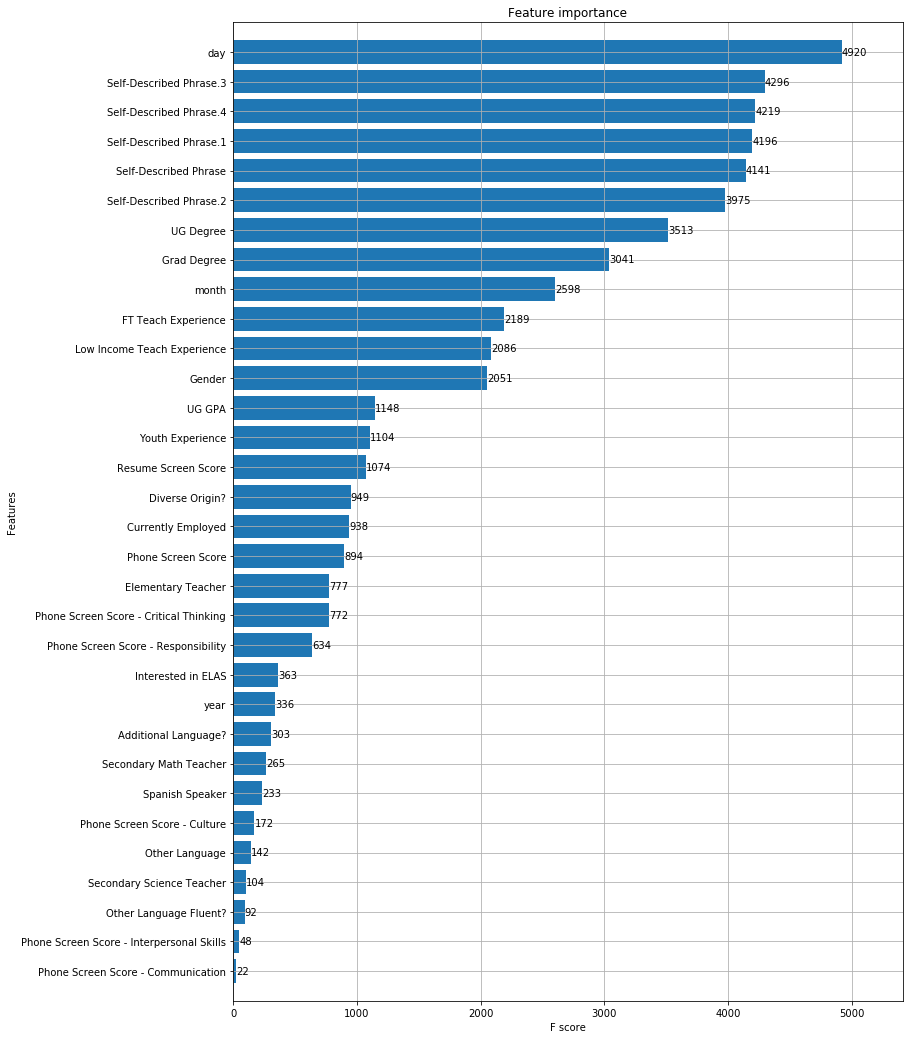

In [678]:
# Let's use the plot f_score XGB feature to see what variable split occurred most.
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

Weird. Day of the application is most important. Why? Then their self descriptions, and then UG major. According to our random forest model, these features are important predictors.

You can read down the chart, with the most predictive variables coming at the top, and the least predictive at the bottom (e.g. 'Phone Screen Score - Communication' was shown to not be predictive, according to our model).

### 2. What (if any) pieces of data do you wish was collected?

I am a data scientist. I'd love more data!

- References from previous schools
- Letters of recommendation
- Student data from previous schools
- Sample lesson of theirs. Either in written form, or ideally, video and audio footage of their classroom work. 
- Free response writing on essay prompts. For example: "Why do you want to work at our school?" I don't know which essay prompts would be predictive, but we could mine data to refine this part of the application over time.

In general, the data scientist in me is a bit agnostic. Give me as much data as possible and we'll let the data and algorithms search for patters.

The teacher in me, though, says that info that gets at the following is most important:

- How have they helped students in past? (e.g. Test score improvement data from past)
- Reviews (e.g. From students and teacher observations)
- Personal traits (e.g. Do they have passion for working with young people, energy, and communication skills?)

We perhaps could have made used the given data to approximate intermediate rankings (for example, combine GPA and major to derive some sort of 'rigor' ranking), but I think that from a prediction perspective, this is not neccessary. 

However, if the goal is model interpretation, then perhaps doing this sort of combination of features to generate a few scores for the applicant along key dimensions would have use.

### 3. What (if any) challenges existed with using and interpreting information from this data set? 

1. No data dictionary given. So I did not have full understanding of the variables. A good data scientist's work is only as effective as the data is complete, and in this case I really had no idea of the integrity of the data with which I was working. What each column really meant was not always clear and needed to be inferred by me.
2. I used Rating Points as my outcome of choice...where did this come from? If, presumably, it was some combination of the other assessment scores, how was it combined, and what inter-rater reliability is there for this data (e.g. does one teacher's score of a 80 mean the same as an 80 for another teacher)?


I resolved this by making assumptions, given the context of the data.
3. The qualititive nature made it harder to derive tangible recommendations for the school district in terms of what specific qualities they ought to search for.

I resolved this by relying upon a mix of sophisticated and basic ML tools. The forest learning algorithm gives some sense of feature importance, but I then combined this with manual inspection of 'Rating Points' means to hint at what feature values are most predictive of teacher success.



### 4. What recommendations would you give to a school district based on these results?

We saw above that things like day, self description, and undergrad major responses matter. Let's dig deeper to see what responses were the good ones.

#### Day (???)

It doesn't really make sense that day of application should make a difference...

In [679]:
# Filter original df by the most common degrees:
day_ranking = pd.DataFrame(original_train_df.groupby('day').mean()['Rating Points']).reset_index()
day_ranking.sort_values(by='Rating Points',ascending = False).head()

,day,Rating Points
20,21,75.039677
15,16,74.760250
27,28,74.586818
16,17,74.505111
10,11,74.462778


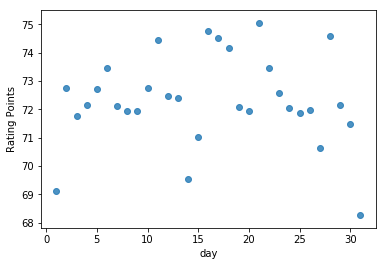

In [680]:
sns.regplot(x='day', y='Rating Points', data = day_ranking, fit_reg=False)

And indeed this scatterplot doesn't show me much of a pattern. Let's move on for now. 

#### Undergrad degree

In [681]:
# Filter original df by the most common degrees:
degree_ranking = pd.DataFrame(original_train_df.groupby('UG Degree').mean()['Rating Points']).reset_index()
degree_ranking.sort_values(by='Rating Points',ascending = False).head()

,UG Degree,Rating Points
7,Not applicable,73.652371
10,Physical Sciences,73.334667
9,Other Degree,72.892368
4,Foreign Language,72.844828
11,Social Science,72.702059


In [682]:
top_degrees = degree_ranking.sort_values(by='Rating Points',ascending = False)[0:10]

In [683]:
top_degrees

,UG Degree,Rating Points
7,Not applicable,73.652371
10,Physical Sciences,73.334667
9,Other Degree,72.892368
4,Foreign Language,72.844828
11,Social Science,72.702059
2,Education,72.445203
3,English,72.408885
0,Art,72.254103
1,Business,71.939000
5,Math,71.814545


In [684]:
x = original_train_df[original_train_df['UG Degree'].isin(set(top_degrees['UG Degree']))]     

/Users/wnowak/anaconda/envs/py35/lib/python3.5/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

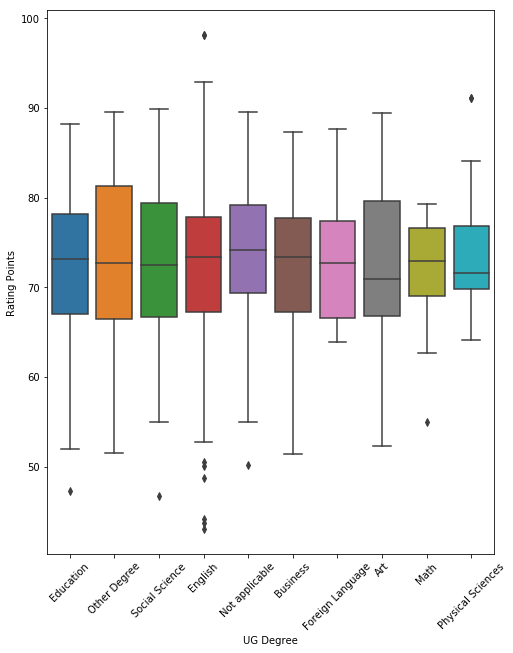

In [685]:
fig, ax = plt.subplots(figsize=(8,10))
g = sns.boxplot(x='UG Degree', y="Rating Points", data=x)
plt.xticks(rotation=45)

Without a ton of confidence, perhaps we have evidence to look for Physical Sciences majors.

#### Self described phrase

In [688]:
# Filter original df by the most common degrees:
self_described = pd.DataFrame(original_train_df.groupby('Self-Described Phrase.1').mean()['Rating Points']).reset_index()
self_described.sort_values(by='Rating Points',ascending = False).head(20)

,Self-Described Phrase.1,Rating Points
27,Primary Elem Exp,78.490000
33,Upper Elem Exp,75.143750
25,Patient,75.068750
4,Content Knowledge Expert,74.977000
32,Risk Taker,74.820000
15,Flexible,74.662813
31,Relationship Builder,74.427593
6,Data Driven,74.016154
11,Encouraging,73.271389
14,Experience with ELLs,73.010526


Given that self description is important, and these are correlated with high scores, I'd encourage schools to seek applicants with these self descriptions (above). 

In [689]:
self_described.sort_values(by='Rating Points',ascending = False).tail(20)

,Self-Described Phrase.1,Rating Points
18,Innovative,72.630000
26,Positive,72.612500
23,Organized,72.503571
29,Reflective,72.475000
8,Detail Oriented,72.468966
3,Confident,72.460408
1,Avid Listener,72.285714
16,Funny,72.272857
22,Open-Minded,71.931600
13,Engaged,71.573333


Similarly, schools should avoid applicants described as 'Problem Solvers', or any other the other low ranked descriptions, according to our data and model.

Again, it should be noted that the previous analysis of important features is not so clear cut. A random forest model searches for features that make useful splits. That is, a useful split is one that, when split upon, leads to relatively 'pure' resulting nodes. So using this metric of feature importance (generated from features that were often split upon) is useful, but perhaps not the ideal way to identify the single characteristics of applicants that most predict success. Instead, this model is likely better at, in sum, predicting applicant success. Trying to tease out individual features must be taken with an acknowledgement that these feature rankings are not iron clad rules.